In [1]:
###############################  Used to make repository and common accessible ####################
import sys
sys.path.insert(0,'c:/MyDocs/OpenFF/src/')
import common.code.Analysis_set_remote as ana_set
import pandas as pd
import numpy as np
ext_refs = 'c:/MyDocs/OpenFF/data/transformed/external_refs/'
out_figs = './fig_images/'

In [2]:
master_df = ana_set.Full_set(repo='v14_2022_04_06').get_set()
master_df['yr'] = master_df.date.dt.year

# Figures for SDWA manuscript
## Version 13
##  Nov 17, 2022 Version

This version zeros out the Chlorine dioxide (and Antimony) masses from the data.  As we describe in the "outlier and suspicious data" section below, Chlorine dioxide masses are especially questionable. We zero out the masses so those chemicals' reported masses are not included in the SDWA-wide mass calculations (in the previous version, this was an issue in the article's Fig 2b).  We keep the records in the analysis because we still want to document that the chemicals were present in their disclosures. 

**Note that the figure numbers in this notebook don't necessarily match the manuscripts figure numbers.** There was some rearranging in the later editing stages that were not updated here.  That means that the file names of saved figures might not match ms fig numbers!

Using the repository from the Main version of CodeOcean v.14


In [3]:
# this code is necessary to keep itables working with new ngcovert templates

from IPython.display import HTML, display
from IPython.display import Markdown as md



In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker
from pylab import gca, mpl
import seaborn as sns; sns.set_theme()
from IPython.display import HTML, display

def iShow(df,maxBytes=0):
    display(df)

# Source data

> ## FracFocus data - main Open-FF ver. 14 as published; bulk download: Apr 2, 2022




In [5]:
# keep only non-duplicated disclosures
master_df = master_df[master_df.in_std_filtered]

In [6]:
casgb = master_df[master_df.in_std_filtered].groupby('bgCAS',as_index=False)['UploadKey'].count()
# used to show number records for each chemical in the FF data below 
casgb.columns = ['CASRN','FF-count']


In [7]:
# find the most commonly reported names in FF for categories we lump: ingredientName, Operator and Supplier
gb = master_df.groupby('bgCAS')['IngredientName'].agg(lambda x: x.value_counts().index[0])
gb = gb.reset_index()
gb.columns = ['bgCAS','common_name']
master_df = pd.merge(master_df,gb,on='bgCAS',how='left')

gb = master_df.groupby('bgSupplier')['Supplier'].agg(lambda x: x.value_counts().index[0])
gb = gb.reset_index()
gb.columns = ['bgSupplier','comm_Sup']
master_df = pd.merge(master_df,gb,on='bgSupplier',how='left')
# we can also use this gb to make a common priSup field
gb.columns = ['primarySupplier','comm_Prim']
master_df = pd.merge(master_df,gb,on='primarySupplier',how='left')

#print(master_df.columns)
gb = master_df.groupby('bgOperatorName')['OperatorName'].agg(lambda x: x.value_counts().index[0])
gb = gb.reset_index()
gb.columns = ['bgOperatorName','comm_Op']
master_df = pd.merge(master_df,gb,on='bgOperatorName',how='left')


### Filtering dates
Although FracFocus became official in 2011, we find historical data in the set. Because we are using only data from the bulk download supplied by the FracFocus, we filter out 2011-2013 (2013 is only a partial year in the bulk data). Additionally, some disclosures have  clearly wrong dates (e.g. fracking dates in the future).  We filter the master set here:

In [8]:
ymin = 2014
ymax = 2021
c1 = master_df.date.dt.year>=ymin
c2 = master_df.date.dt.year<=ymax
master_df = master_df[c1&c2]
num_disclosures = len(master_df.UploadKey.unique())

---
## Filtering out outlier or suspicious data
After examining the chemical records for potential outliers that could bias our total mass reports, we remove the following records:

- All records of Chlorine dioxide (10049-04-4). There are a large number of disclosures that claim 100% of the job is this chemical and don't report percentHFJob for all the other chemicals listed. Further, when more reasonable numbers are used, it is most often not recorded if the PercentHFJob refers to chlorine dioxide as a gas or in an aqueous solution (though some disclosures specify one or the other of those).  Finally, even if we assumed it was mostly aqueous, there is rarely record of the concentration.
- All records of Antimony (7440-36-0).  There are only 2 records in the filtered data set and both are identified only by their IngredientName; the CAS number is missing.

- The records of Epichlorohydrin (106-89-8) that have the TradeName of "Super 100NE". Many of these are marked as proprietary **quantities** and give a PercentHFJob value that is far too large.

#### Note that because we are now filtering out 2011-2013, many of these previously identified outliers would not have been included anyway.

In [9]:
# added Nov 17, 2022.  See v13 note.
c = master_df.bgCAS.isin(['10049-04-4','7440-36-0'])
master_df.calcMass = np.where(c,np.NaN,master_df.calcMass)

In [10]:
c1 = master_df.bgCAS=='106-89-8'
c2 = master_df.TradeName == 'Super 100NE'
print(f'Number to modify: {(c1&c2).sum()} (some already had no calcMass)')
master_df.calcMass = np.where((c1&c2),np.NaN,master_df.calcMass)

Number to modify: 0 (some already had no calcMass)


- The following individual records that have some quirks that suggest they may be errors.


In [11]:
target_ingKeys = ['3e00a4ae-e593-41ba-be48-5c927a8238c4', #  106-89-8, 2013, odd disclosure, much larger than others
                  '8e497c11-f015-4d7e-acca-a44e49d905f8', # next three are formaldehyde. All very large and are suspicious
                  'a28613ed-37f4-45aa-9496-2d48f2c7a48d',
                  '85248136-bee7-4fd7-8a86-16b3e0f23612',
                  'a6be0904-a674-4437-85c7-4c28a51204e7' ] # napthalene, biggest record, claims almost 10% for %HFJ]
c1 = master_df.IngredientKey.isin(target_ingKeys)
print(f'Number to modify: {(c1).sum()} ')
master_df.calcMass = np.where((c1),np.NaN,master_df.calcMass)

Number to modify: 1 


## SDWA data sets
### compiled from EPA CompTox lists and the Primary Drinking Water Standards 

In this version, we use the directly loaded data from CompTox list, and what we label them in the analysis below:

- [WATER|EPA: Drinking Water Standard and Health Advisories Table](https://comptox.epa.gov/dashboard/chemical_lists/EPADWS) Called **EPADWS**

- The National Primary Drinking Water Regulation list compiled by Angelica from a few sources. This list has been vetted against Comptox to verify that all CAS numbers are valid.  [View the list here.](https://drive.google.com/file/d/11bAcqNLdZm0UYh2hMRL4HuPN4LB5Yfx5/view?usp=sharing)  Called **NPDWR**

### Note that with v14 these are included in the data directly
but still added here for consistency

In [12]:
# SDWA
epadwsfn = r"C:\MyDocs\OpenFF\data\external_refs\NE_list_comparison\Chemical List EPADWS-2022-02-04.csv"
npdwrfn = r"C:\MyDocs\OpenFF\data\external_refs\NE_list_comparison\NationalPrimaryDrinkingWaterRegulations_machine_readable_FEB2022.csv"
names = {'EPADWS' : epadwsfn,
         'NPDWR' : npdwrfn}

In [13]:
for n in names.keys():
    print(f'working on adding {n}')
    sdf = pd.read_csv(names[n])
    sdf[n] = 'Yes'
    master_df = pd.merge(master_df,sdf[[n,'CASRN']],left_on='bgCAS',right_on='CASRN',how='left')
    master_df = master_df.drop('CASRN',axis=1)
    
# make lists for venn diagrams also
epadws_cas = pd.read_csv(epadwsfn).CASRN.tolist()

working on adding EPADWS
working on adding NPDWR


---
## Venn diagram
The number of chemicals in the FF set is all materials that are labeled with a CAS number.


In [14]:
# pairwise comparisons - first without considering FF
from matplotlib_venn import venn3
# make lists for venn diagrams also
epadws_cas = pd.read_csv(epadwsfn).CASRN.tolist()
npdwr_cas = pd.read_csv(npdwrfn).CASRN.tolist()
ff_cas = master_df[master_df.bgCAS.str[0].isin(['0','1','2','3','4','5','6','7','8','9'])].bgCAS.unique().tolist()

In [15]:
print(f'List lengths: EPADWS: {len(epadws_cas)}, NPDWR: {len(npdwr_cas)}, FF: {len(ff_cas)}')

List lengths: EPADWS: 212, NPDWR: 96, FF: 1240


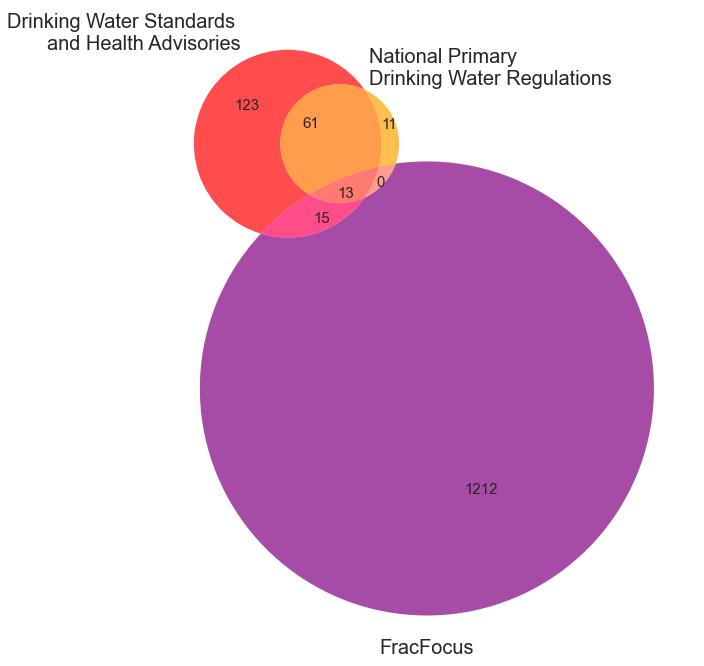

In [16]:
plt.figure(figsize=(12,12))
out = venn3([set(epadws_cas), 
       set(npdwr_cas), 
       set(ff_cas)], ('Drinking Water Standards \nand Health Advisories',
                      'National Primary \nDrinking Water Regulations', 
                      'FracFocus'),set_colors=('red', 'orange','purple'), alpha = 0.7);

for text in out.set_labels:
   text.set_fontsize(20)

for text in out.subset_labels:
   text.set_fontsize(15)
plt.savefig(out_figs+'venn.png',pad_inches=1,bbox_inches = 'tight', dpi = 900)

### To do for this FIG:
- Adjust positions of titles?


In [17]:
from math import log10, floor
def round_sig(x, sig=2):
    try:
        if abs(x)>=1:
            out =  int(round(x, sig-int(floor(log10(abs(x))))-1))
            return f"{out:,d}" # does the right thing with commas
        else: # fractional numbers
            return str(round(x, sig-int(floor(log10(abs(x))))-1))
    except:
        return x
    

## Fig 3A?

Total number of disclosures in data set: 117515



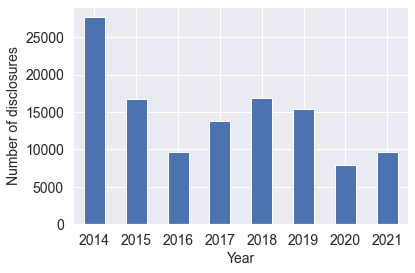

,yr,sdwa_disc,tot_disc,percent_with_SDWA_chem,SDWA_mass,mSDWA_mass
0,2014,20239,27652,73.191813,6.535066e+07,65.350663
1,2015,12224,16677,73.298555,4.696448e+07,46.964476
2,2016,6639,9611,69.077099,2.533438e+07,25.334380
3,2017,9569,13806,69.310445,4.328007e+07,43.280069
4,2018,11540,16876,68.381133,4.705406e+07,47.054061
5,2019,10021,15384,65.139106,3.188604e+07,31.886040
6,2020,4955,7903,62.697710,1.222688e+07,12.226877
7,2021,5932,9606,61.753071,1.007262e+07,10.072620


,yr,propri_disc,tot_disc,percent_with_Trade_Secret,prop_mass,mProp_mass
0,2014,21917,27652,79.260090,7.263475e+08,726.347511
1,2015,12843,16677,77.010254,5.051066e+08,505.106558
2,2016,7882,9611,82.010197,3.837359e+08,383.735934
3,2017,11677,13806,84.579168,5.793419e+08,579.341899
4,2018,14353,16876,85.049775,1.200461e+09,1200.461488
5,2019,12544,15384,81.539262,1.127098e+09,1127.098262
6,2020,6738,7903,85.258762,9.622225e+08,962.222530
7,2021,8427,9606,87.726421,1.674861e+09,1674.861361


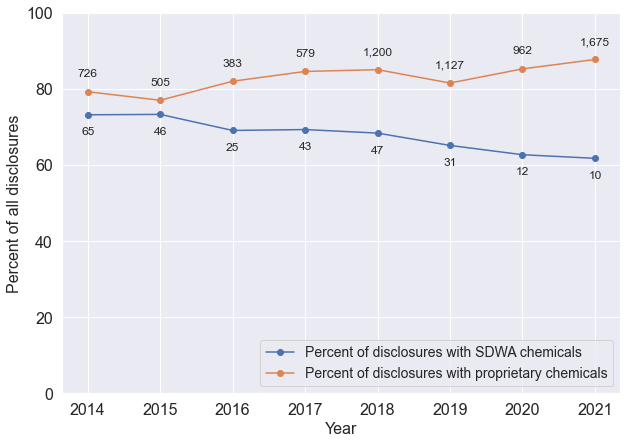

In [18]:
from matplotlib.offsetbox import AnchoredText

print(f'Total number of disclosures in data set: {len(master_df.UploadKey.unique())}\n')
#get number disclosures/yr
tmp = master_df.groupby(['UploadKey','yr'],as_index=False)['bgCAS'].count()
tot_yr = tmp.groupby('yr',as_index=False)['UploadKey'].count().rename({'UploadKey':'tot_disc'},axis=1)
ax = tot_yr.plot.bar('yr','tot_disc',legend=False)
plt.title('')
ax.set_ylabel('Number of disclosures',fontsize= 14)
ax.set_xlabel('Year',fontsize= 14)
plt.xticks(fontsize=14,rotation = 0);
plt.yticks(fontsize=14,rotation = 0);
plt.savefig(out_figs+'fig2a.png',pad_inches=1,bbox_inches = 'tight', dpi = 900)
plt.show()

# now get num disc for each chemical by year AND calcmass per year
t = master_df[master_df.EPADWS=='Yes'].groupby(['UploadKey','yr'],as_index=False)['bgCAS'].count()
disc_yr = t.groupby('yr',as_index=False)['UploadKey'].count().rename({'UploadKey':'sdwa_disc'},axis=1)
disc_yr = pd.merge(disc_yr,tot_yr,on='yr',how='left')
disc_yr['percent_with_SDWA_chem'] = disc_yr.sdwa_disc/disc_yr.tot_disc *100
t = master_df[master_df.EPADWS=='Yes'].groupby(['UploadKey','yr'],as_index=False)['calcMass'].sum()
t = t.groupby('yr',as_index=False)['calcMass'].sum().rename({'calcMass':'SDWA_mass'},axis=1)
t['mSDWA_mass'] = t.SDWA_mass/1000000
disc_yr = pd.merge(disc_yr,t,on='yr',how='left')
display(disc_yr)


# lets look at proprietary claims
t = master_df[master_df.bgCAS=='proprietary'].groupby(['UploadKey','yr'],as_index=False)['bgCAS'].count()
pdisc_yr = t.groupby('yr',as_index=False)['UploadKey'].count().rename({'UploadKey':'propri_disc'},axis=1)
pdisc_yr = pd.merge(pdisc_yr,tot_yr,on='yr',how='left')
pdisc_yr['percent_with_Trade_Secret'] = pdisc_yr.propri_disc/pdisc_yr.tot_disc *100
t = master_df[master_df.bgCAS=='proprietary'].groupby(['UploadKey','yr'],as_index=False)['calcMass'].sum()
t = t.groupby('yr',as_index=False)['calcMass'].sum().rename({'calcMass':'prop_mass'},axis=1)
t['mProp_mass'] = t.prop_mass/1000000
pdisc_yr = pd.merge(pdisc_yr,t,on='yr',how='left')
display(pdisc_yr)

# now put the two together
mg = pd.merge(disc_yr,pdisc_yr,on='yr',how='inner')
#ax = mg.plot.bar('yr',['percent_with_SDWA_chem','percent_with_Trade_Secret'],figsize=(10,7),ylim=(0,100))
ax = mg.plot.line('yr',['percent_with_SDWA_chem','percent_with_Trade_Secret'],figsize=(10,7),ylim=(0,100),
                  style='o-')
ax.set_title('');
ax.set_ylabel('Percent of all disclosures',fontsize= 16)
ax.set_xlabel('Year',fontsize= 16)
plt.yticks(fontsize=16);
plt.xticks(fontsize=16,rotation = 0);
ax.legend(['Percent of disclosures with SDWA chemicals', 'Percent of disclosures with proprietary chemicals'],
         fontsize=14,loc='lower right');
for i,row in mg.iterrows():
    #first SDWA
    xy = (row.yr,row.percent_with_SDWA_chem)
    label = f'{round_sig(row.mSDWA_mass,4)}'
    plt.annotate(text=label, xy=xy,textcoords="offset points",xytext=(0,-20),ha='center')
    # next proprietary
    xy = (row.yr,row.percent_with_Trade_Secret)
    label = f'{round_sig(row.mProp_mass,4)}'
    plt.annotate(text=label, xy=xy,textcoords="offset points",xytext=(0,15),ha='center')
    
plt.savefig(out_figs+'fig1a.png',pad_inches=1,bbox_inches = 'tight', dpi = 900)

---
#  Table 1

In [19]:
# pull in health effects list
heal_eff = pd.read_excel(r"C:\MyDocs\OpenFF\data\external_refs\NE_list_comparison\SDWA Table- Health Effects.xls")
iris_eff = pd.read_excel(r"C:\MyDocs\OpenFF\data\external_refs\NE_list_comparison\IRIS List of Health Effects.xlsx")

heal_eff.rename({'CAS Number':'bgCAS'},axis=1,inplace=True)
heal_eff.fillna(' ',inplace=True)
heal_eff.drop(['Common Name','Ingredient Name'],axis=1,inplace=True)
heal_eff.head()
iris_eff.rename({'CASRN':'bgCAS'},axis=1,inplace=True)
iris_eff = iris_eff.filter(['bgCAS','Critical Effect Systems'],axis=1)
iris_eff.columns = ['bgCAS','System Effects']
iris_eff.fillna('-',inplace=True)
iris_eff.head()
heal_eff = pd.merge(heal_eff,iris_eff,on='bgCAS',how='left')

#heal_eff.head()
# # heal_eff

In [20]:
# Use the EPA "preferred names" throughout
dwslst = pd.read_csv(epadwsfn)[['CASRN','PREFERRED NAME']]
dwslst.columns = ['bgCAS','epa_preferred_name']
master_df = pd.merge(master_df,dwslst,on='bgCAS',how='left')
to_remove_from_mass = ['10049-04-4','7440-36-0','7440-42-8']

In [22]:
t = master_df[master_df.EPADWS=='Yes']
tot_disc = len(master_df.UploadKey.unique())
gb = t.groupby('bgCAS',as_index=False)['epa_preferred_name'].first()
gb1 = t.groupby(['bgCAS','UploadKey'],as_index=False)['bgIngredientName'].count()
gb1 = gb1.groupby('bgCAS',as_index=False)['UploadKey'].count().rename({'UploadKey':'num_disclosures'},axis=1)
gb = pd.merge(gb,gb1,on='bgCAS',how='left')
gb1 = t[t.calcMass>0].groupby(['bgCAS','UploadKey'],as_index=False)['calcMass'].count() #.rename({'calcMass':'recs_with_calcMass'},axis=1)
gb1 = gb1.groupby('bgCAS',as_index=False)['UploadKey'].count().rename({'UploadKey':'disc_with_calcMass'},axis=1)
gb = pd.merge(gb,gb1,on='bgCAS',how='left')
gb['perc_of_all_disclosures'] = gb.num_disclosures/tot_disc*100
gb1 = t[t.calcMass>0].groupby('bgCAS',as_index=False)['calcMass'].sum().rename({'calcMass':'total_mass_reported'},axis=1)
#gb1.total_mass_reported = gb1.total_mass_reported.map(lambda x: round_sig(x, sig=3))
gb = pd.merge(gb,gb1,on='bgCAS',how='left')


gb = pd.merge(gb,heal_eff,on='bgCAS',how='left')

gb.insert(0, 'epa_preferred_name', gb.pop('epa_preferred_name'))


gb = gb.sort_values('total_mass_reported',ascending=False)
gb['Notes'] = ''
gb.Notes = np.where(gb.bgCAS.isin(to_remove_from_mass),'Do not report MASS?',gb.Notes)

# now make the numbers presentable
gb.num_disclosures = gb.num_disclosures.map(lambda x: str(int(round(x,0))))
gb.disc_with_calcMass.fillna(0,inplace=True)
gb.disc_with_calcMass = gb.disc_with_calcMass.map(lambda x: str(int(round(x,0))))
gb.perc_of_all_disclosures = gb.perc_of_all_disclosures.map(lambda x: round_sig(x,2))
gb.total_mass_reported = gb.total_mass_reported.map(lambda x: round_sig(x,2))

rq = pd.read_csv('RQ_values.csv')
gb = pd.merge(gb,rq,on='bgCAS',how='left')

gb.columns = ['Name','CAS Number','Number of disclosures','Number of disclosures with calculable mass','Percent of all disclosures',
              'Total calculable mass reported', 'MCL (mg/L)', 'RfD (mg/kg/day)','Critical effects','System effects',
              'Notes','Reportable quantity']

gb[['Name','CAS Number','Number of disclosures','Percent of all disclosures','Number of disclosures with calculable mass',
    'Total calculable mass reported', 'MCL (mg/L)', 'RfD (mg/kg/day)','Critical effects',
    'System effects',
    'Reportable quantity']].to_csv('./tmp/SDWA_table1.csv',index=False)
gb

,Name,CAS Number,Number of disclosures,Number of disclosures with calculable mass,Percent of all disclosures,Total calculable mass reported,MCL (mg/L),RfD (mg/kg/day),Critical effects,System effects,Notes,Reportable quantity
0,Ethylene glycol,107-21-1,52674,46094,45,"250,000,000",,2.0,kidney toxicity,Urinary,,5000.0
1,Naphthalene,91-20-3,15377,13299,13,"10,000,000",,0.02,reduced mean terminal body weight (males),Nervous\nRespiratory,,100.0
2,Benzene,71-43-2,111,101,0.094,"7,500,000",0.001,0.004,reduced lymphocyte count,Immune,,10.0
3,Acrylamide,79-06-1,22065,17634,19,"4,600,000",,0.002,nonneoplastic histopathology; Degenerative ner...,Nervous,,5000.0
4,Xylenes,1330-20-7,2641,2189,2,"3,600,000",10.0,0.2,"reduced body weight, increased mortality",Nervous,,100.0
5,"1,2,4-Trimethylbenzene",95-63-6,12862,10977,11,"2,700,000",,0.01,reduced pain sensitivity in male wistar rats,Developmental\nHematologic\nNervous\nRespiratory,,NaN
6,Formaldehyde,50-00-0,14370,11009,12,"1,800,000",5.0,0.2,"Reduced weight gain, histopathology in rats",Gastrointestinal\nUrinary,,100.0
7,Ethylbenzene,100-41-4,1819,1334,1,"940,000",0.3,0.1,liver and kidney toxicity,Developmental\nHepatic\nUrinary,,1000.0
8,Ammonia,7664-41-7,1503,1267,1,"550,000",,0.97,respiratory system,Respiratory,,100.0
9,Phenol,108-95-2,302,160,0.26,"150,000",,0.3,reduced maternal weight gain,None,,1000.0


### To do for this TABLE (Manually):
- Make excel version that has appropriate titles and correct rounding
- Remove Mass from Boron, Antimony and Choline dioxide **Two Columns**.
- Put in markers for chems without RQ: Chlorine dioxide 	10049-04-4
	1,2,4-Trimethylbenzene 	95-63-6
	1,3,5-Trimethylbenzene 	108-67-8
	Chlorite 	14998-27-7
	Boron 	7440-42-8
- Sort table by number of disclosures  



# Figure 3

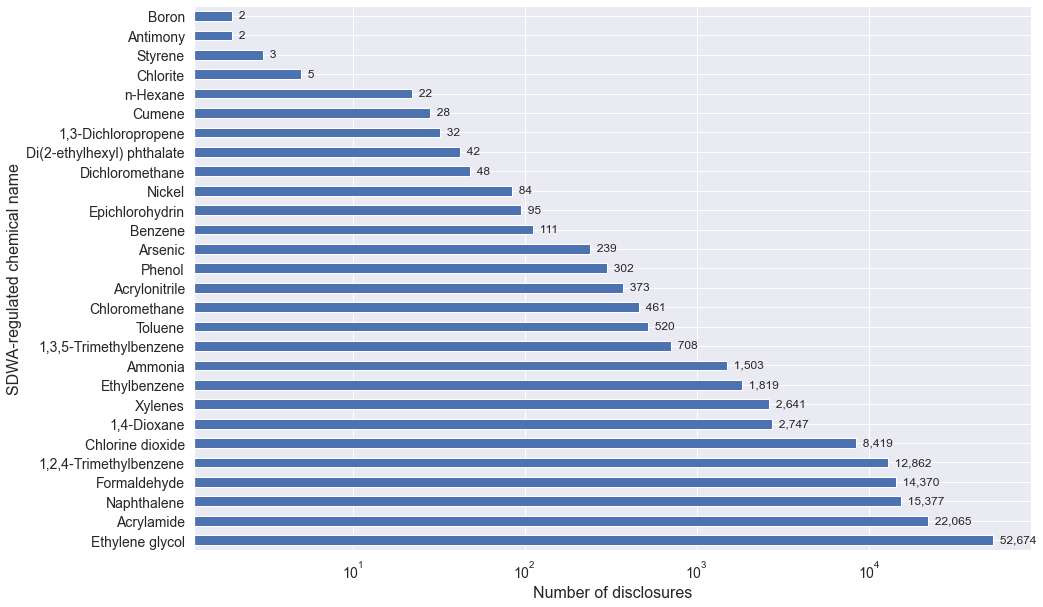

In [23]:
gb['num_disclosures'] = gb['Number of disclosures'].astype('int')
gb = gb.sort_values('num_disclosures',ascending=False)
ax = gb.plot.barh('Name','num_disclosures',figsize=(15,10),logx=True,legend=False)
ax.tick_params(axis="y", labelsize=14)
ax.tick_params(axis="x", labelsize=14)
plt.xlabel('Number of disclosures',fontsize=16);
plt.ylabel('SDWA-regulated chemical name',fontsize=16);
#plt.title('Number of disclosures reporting chemicals on SDWA lists',fontsize=20);
plt.title('');
for p in ax.patches:
    width = p.get_width()
    nw = f'  {round_sig(width,5)}' # don't need sig_fig constraints on counts
    plt.text(p.get_width(), p.get_y()+0.55*p.get_height(),
             nw,
             ha='left', va='center')
    
plt.savefig(out_figs+'fig2.png',pad_inches=1,bbox_inches = 'tight', dpi = 900)

### To do for this FIG:



---
# Figure 1b (?)

Number of disclosures with ZERO of these chemicals:     36396 or 30.971365%
Median number of these chemicals used/frack:       1.0
Average number of these chemicals used/frack:       1.1705229119686849
Maximum number of these chemicals used in a frack: 7.0





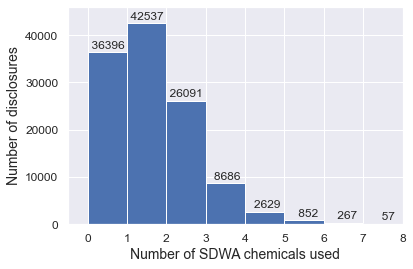

In [24]:
def numCASperFrack(master,set_name):
    # note that we have to group by bgCAS first, because some fracks report each PHASE: therefore multiple
    # hits for every chemical.
    # here, bgCAS is total number of CAS/frack for all fracs 
    gb = master.groupby(['UploadKey','bgCAS'],as_index=False)[[set_name]].first()
    gb1 = gb.groupby('UploadKey',as_index=False)['bgCAS'].count()
    gb1.columns= ['UploadKey','tot_CAS']
    gb2 = gb[gb[set_name]=='Yes'].groupby('UploadKey',as_index=False)['bgCAS'].count()
    gb2.columns= ['UploadKey','listed_CAS']
    mg = pd.merge(gb1,gb2,on='UploadKey',how='left')
    mg.listed_CAS.fillna(0,inplace=True)
    perc_without = ((mg.listed_CAS==0).sum())/len(mg)
    print(f'Number of disclosures with ZERO of these chemicals:     {(mg.listed_CAS==0).sum()} or {perc_without:%}')
    print(f'Median number of these chemicals used/frack:       {mg.listed_CAS.median()}')
    print(f'Average number of these chemicals used/frack:       {mg.listed_CAS.mean()}')
    print(f'Maximum number of these chemicals used in a frack: {mg.listed_CAS.max()}\n\n\n')
#     ax = mg.listed_CAS.hist(bins=[x for x in range(8)])
#     ax.set_ylabel('Number of disclosures')
#     #ax.set_title('Number of SDWA chemicals reported in disclosures',fontsize=16)
#     ax.set_title('')


    fig, ax = plt.subplots()
    n, bins, patches = ax.hist(mg.listed_CAS,bins=[x for x in range(10)])
    bars = ax.bar(bins[:-2],n[:-1],width=0)
    ax.set_ylabel('Number of disclosures',fontsize=14);
    ax.set_xlabel('Number of SDWA chemicals used',fontsize=14)
    ax.bar_label(bars,label_type='edge',padding=2,fmt='            %5i')
    plt.xticks(rotation=0,fontsize=12);
    plt.yticks(rotation=0,fontsize=12);
    plt.xlim([-.5, 8]);
    plt.ylim([0,46000]);
    plt.savefig(out_figs+'fig1c.png',pad_inches=1,bbox_inches = 'tight', dpi = 900)
numCASperFrack(master_df,'EPADWS')

### To do for this FIG:



# Figure 4 - mass by year

In [25]:
# first need to get mass of each chemical by year

# clean up the common_name...
master_df.common_name = np.where(master_df.common_name=='methyl chloride - ts','methyl chloride',master_df.common_name)

#caslst = master_df[master_df.EPADWS=='Yes'].common_name.unique().tolist()
caslst = master_df[master_df.EPADWS=='Yes'].epa_preferred_name.unique().tolist()
#print(caslst)
for cas in ['Chlorine dioxide','Antimony']:
    #print(cas)
    caslst.remove(cas)
#print()

big  = pd.DataFrame({'date':[]})
for cas in caslst:
    #print(cas)
    gb = master_df[master_df.epa_preferred_name==cas].groupby('date')['calcMass'].sum()
    yrly = gb.resample("Y").sum()
    yrly.reset_index(drop=True)
    yrly.columns = ['date',cas]
    #print(yrly)
    big = pd.merge(big,yrly,on='date',how='outer')
    big = big.rename({'calcMass':cas},axis=1)
    #print(big)
big = big.fillna(0)
big.date = big.date.dt.year

# #print(big.columns)
# nonbtex = big.drop(btex,axis=1)

In [26]:
# print BTEX masses for use in text of ms

print(f'Mean 1,4-Dioxane : {big["1,4-Dioxane"].mean()}')
big[['date','Xylenes','Benzene','Ethylene glycol','Naphthalene','1,2,4-Trimethylbenzene','Phenol','1,4-Dioxane']]
big.to_csv('./tmp/data_for_big_figure.csv',encoding='utf-8',index=False)

Mean 1,4-Dioxane : 3790.094730312475


In [27]:
# maxes = nonbtex.max().drop('date',axis=0)
maxes = big.max().drop('date',axis=0)
maxes = maxes.sort_values(ascending=False)
#print(maxes)
breaks = [2,11]
biggest = maxes[:breaks[0]].index.tolist()
#biggest
middle = maxes[breaks[0]:breaks[1]].index.tolist()
#middle
smallest = maxes[breaks[1]:].index.tolist()
tiny = smallest[5:]
lump = []
for i,row in big.iterrows():
    accum = 0
    for chem in tiny:
        accum += row[chem]
    lump.append(accum)
big['remaining 10 \nSDWA chemicals'] = lump
trimmed_smallest = smallest[:5]
trimmed_smallest.append('remaining 10 \nSDWA chemicals')


In [28]:
print(tiny)

['Styrene', 'Dichloromethane', 'Di(2-ethylhexyl) phthalate', 'Nickel', 'Cumene', 'Arsenic', 'Epichlorohydrin', 'n-Hexane', 'Chloromethane', 'Boron']


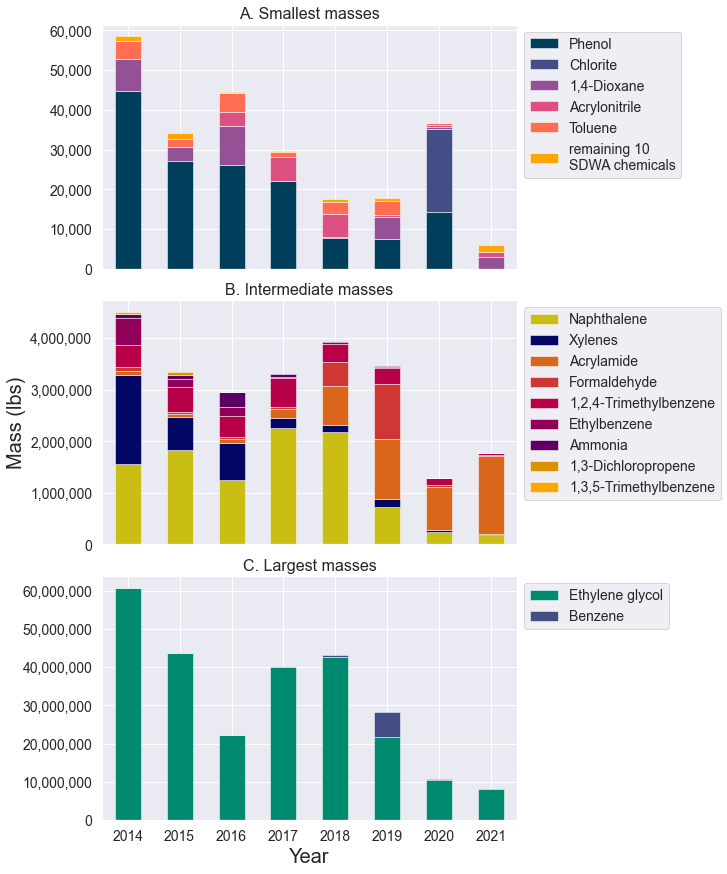

In [29]:
fig = plt.figure(figsize=(10,12),constrained_layout=True)
gs = fig.add_gridspec(3, 1, hspace=0, wspace=0)
(ax1, ax2, ax3) = gs.subplots(sharex='col')
#fig.suptitle('Reported masses of SDWA chemicals',fontsize=20)

#cl1 =['#030764', '#7BC8F6', '#FFD700', '#00FFFF', '#000000','#F97306']
cl1 =['#003f5c', '#444e86', '#955196', '#dd5182', '#ff6e54','#ffa600'] # adjusted by LV (nov 1, 2022)

plt.sca(ax1) #set current axis
big.plot.bar('date',trimmed_smallest,stacked=True, ax=ax1,color=cl1,linewidth=0.5)
ax1.set_title('A. Smallest masses',fontsize=16)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1,fontsize=14)
#ptr = len(ax1.get_yticklabels())-1
#ax1.get_yticklabels()[6].set_color("red")
ax1 = gca().yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.xticks(rotation=0,fontsize=14);
plt.yticks(rotation=0,fontsize=14);

# cl2 =['#030764', '#7BC8F6', '#FFD700', '#00FFFF', '#000000', '#F97306', 
#       '#FFFFFF', '#800080', '#653700', '#E6E6FA'] # <<<<< change colors here
cl2 =['#cabd14', '#030764', '#da661c', '#cf3734', '#b70048', '#910059', 
      '#5e0063', '#d89300', '#ffa600', '#E6E6FA'] # adjusted by LV (nov 1, 2022)
plt.sca(ax2) #set current axis
big.plot.bar('date',middle,stacked=True, ax=ax2,color=cl2,linewidth=0.5)
ax2.set_title('B. Intermediate masses',fontsize=16)
ax2.set_ylabel('Mass (lbs)',fontsize=20);
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1,fontsize=14)
#ptr = len(ax1.get_yticklabels())-1
#ax1.get_yticklabels()[6].set_color("red")
ax2 = gca().yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.xticks(rotation=0,fontsize=14);
plt.yticks(rotation=0,fontsize=14);

# cl3 =['#030764','#FFD700'] # <<<<< change colors here
cl3 =['#008b71','#444e84'] # adjusted by LV (nov 1, 2022)
plt.sca(ax3) #set current axis
big.plot.bar('date',biggest,stacked=True, ax=ax3,color=cl3,linewidth=0.5)
ax3.set_title('C. Largest masses',fontsize=16)
ax3.set_xlabel('Year',fontsize=20);
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1,fontsize=14)
#ptr = len(ax1.get_yticklabels())-1
#ax1.get_yticklabels()[6].set_color("red")
ax3 = gca().yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.xticks(rotation=0,fontsize=14);
plt.yticks(rotation=0,fontsize=14);

plt.savefig(out_figs+'fig4.png',pad_inches=1,bbox_inches = 'tight', dpi = 900)

---


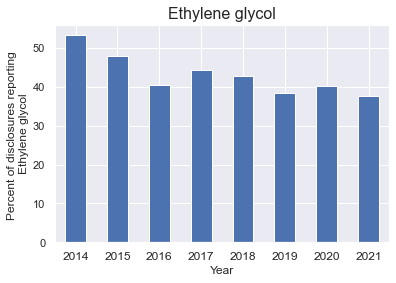

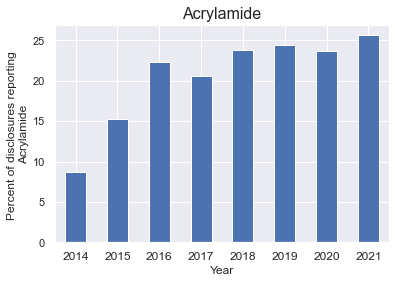

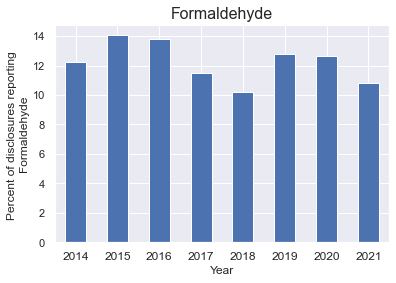

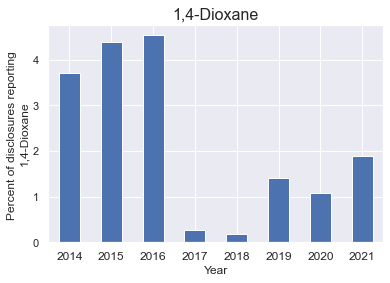

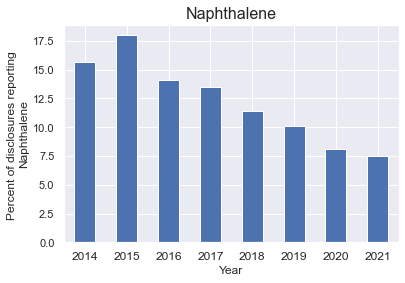

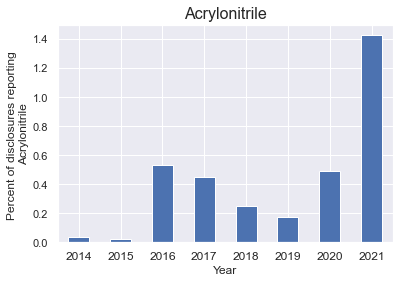

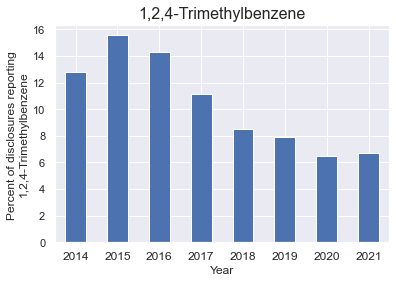

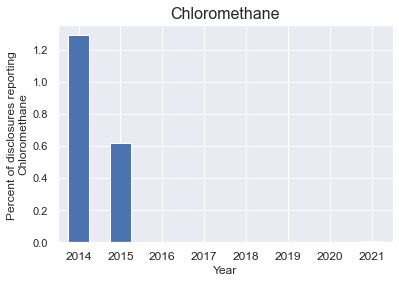

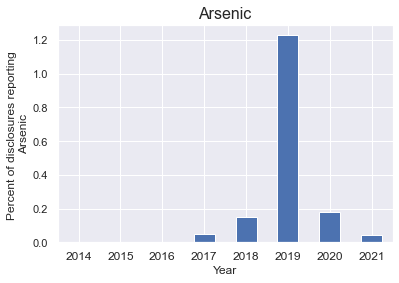

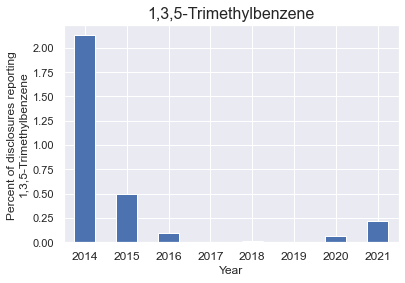

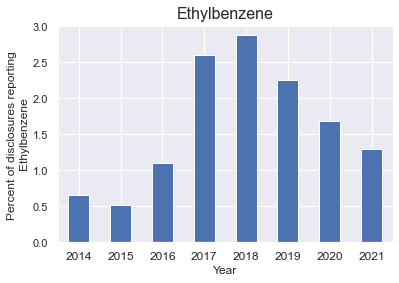

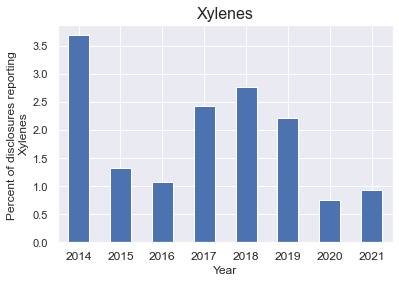

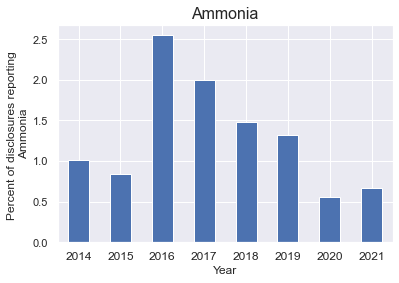

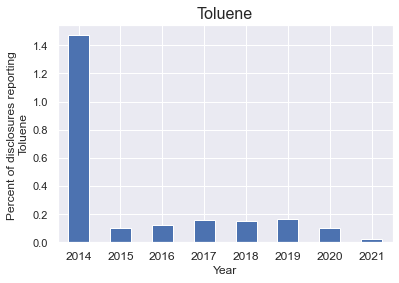

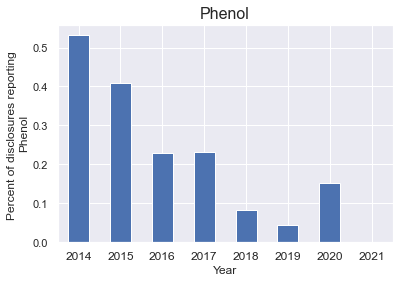

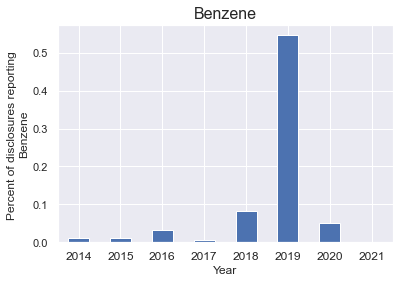

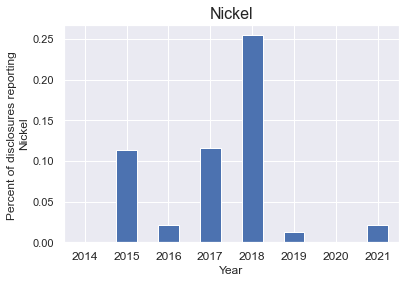

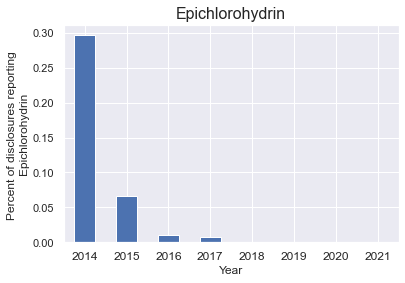

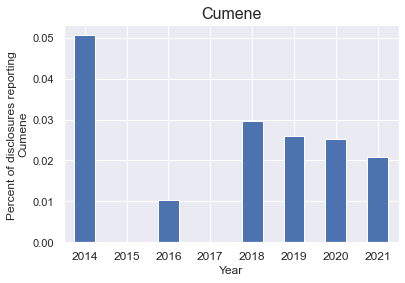

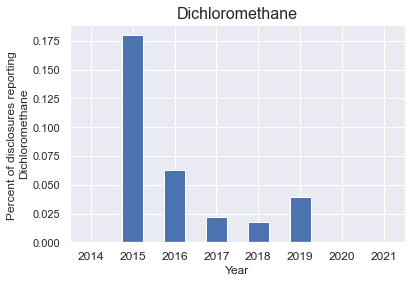

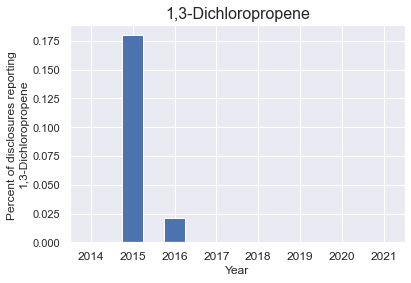

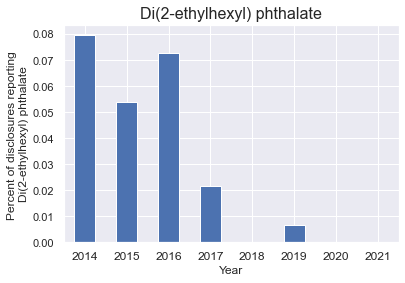

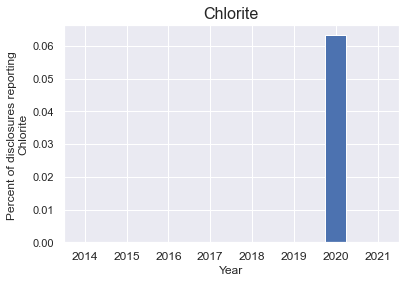

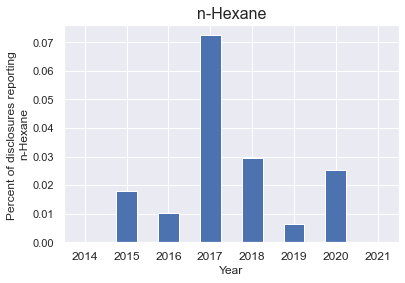

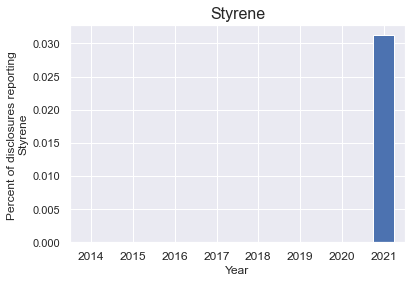

In [30]:
# print(f'Total number of disclosures in data set: {len(master_df.UploadKey.unique())}\n')
#get number disclosures/yr
tmp = master_df.groupby(['UploadKey','yr'],as_index=False)['bgCAS'].count()
tot_yr = tmp.groupby('yr',as_index=False)['UploadKey'].count().rename({'UploadKey':'tot_disc'},axis=1)
# tot_yr.plot.bar('yr','tot_disc',color='green')
# plt.title(f'Total number of disclosures per year',fontsize=16)
# now get num disc for each chemical by year

caslst = master_df[master_df.EPADWS=='Yes'].epa_preferred_name.unique().tolist()
#print(caslst)
for cas in ['Chlorine dioxide','Antimony','Boron']:
    #print(cas)
    caslst.remove(cas)
bigA  = pd.DataFrame({'yr':[]})
#caslist = [TESTNAME]

for cas in caslst:
    #print(cas)
    gb = master_df[master_df.epa_preferred_name==cas].groupby(['yr','UploadKey'],as_index=False)['bgCAS'].count()
    gb1 = gb.groupby('yr',as_index=False)['UploadKey'].count().rename({'UploadKey':'num_disc'},axis=1)
    gb1 = pd.merge(gb1,tot_yr,on='yr',how='left')
    gb1[cas] = gb1.num_disc/gb1.tot_disc * 100
    gb1.drop(['num_disc','tot_disc'],axis=1,inplace=True)
    bigA = pd.merge(bigA,gb1,on='yr',how='outer')
    ax = bigA.plot.bar('yr',cas,legend=False)
    ax.set_ylabel(f'Percent of disclosures reporting \n{cas}')    
    ax.set_xlabel('Year')    
    plt.xticks(rotation=0,fontsize=12);
    plt.title(f'{cas}',fontsize=16)
    plt.savefig(out_figs+f'percent_by_year_{cas}.png',pad_inches=1,bbox_inches = 'tight', dpi = 900)
    plt.show()

---
# Company Figures
## OperatorName

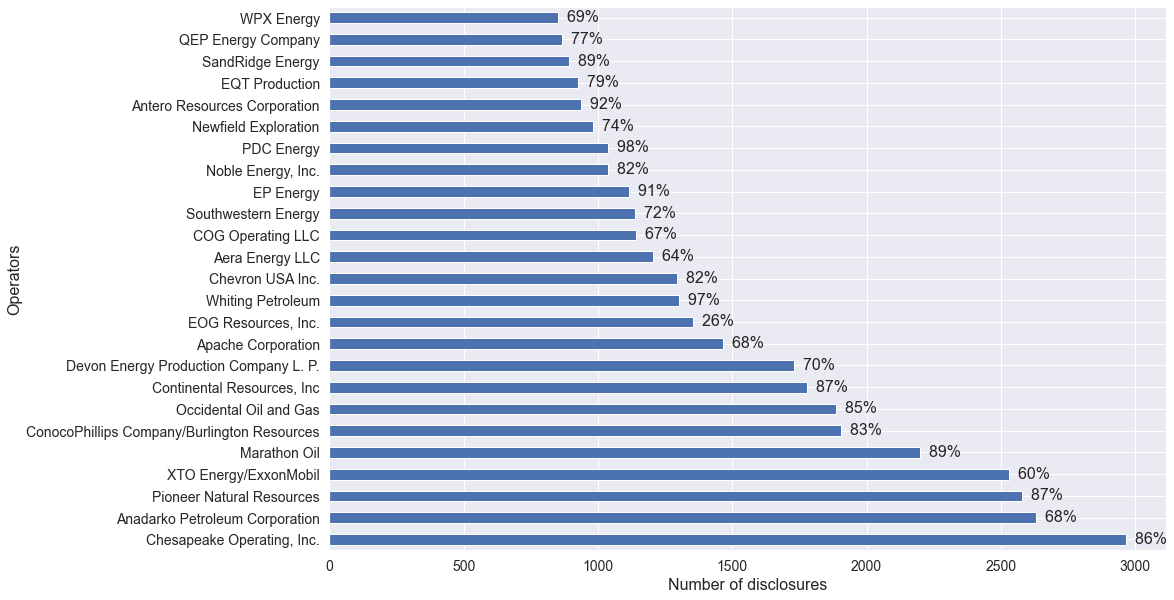

In [31]:
num_comp=25
#get number disclosures/yr
tmp = master_df.groupby(['UploadKey','comm_Op'],as_index=False)['bgCAS'].count()
tot_comp = tmp.groupby('comm_Op',as_index=False)['UploadKey'].count().rename({'UploadKey':'tot_disc'},axis=1)


t = master_df[master_df.EPADWS=='Yes']
gb = t.groupby(['comm_Op','UploadKey'],as_index=False)['bgCAS'].count()
gb1 = gb.groupby('comm_Op',as_index=False)['UploadKey'].count().rename({'UploadKey':'num_disclosures'},axis=1)
gb1 = pd.merge(gb1,tot_comp,on='comm_Op',how='left')
gb1['perc_disc'] = gb1.num_disclosures/gb1.tot_disc * 100
gb1 = gb1.sort_values('num_disclosures',ascending=False)


ax = gb1[:num_comp].plot.barh('comm_Op','num_disclosures',figsize=(15,10),legend=False)
ax.tick_params(axis="y", labelsize=14)
ax.tick_params(axis="x", labelsize=14)
plt.xlabel('Number of disclosures',fontsize=16);
plt.ylabel('Operators',fontsize=16)
#plt.title('OPERATORS: Number of disclosures reporting chemicals on SDWA lists',fontsize=20);
perc_lst = gb1[:num_comp].perc_disc.tolist()
for i,p in enumerate(ax.patches):
    width = p.get_width()
    #nw = f'  {round_sig(width,8)}'
    nw = f'  {int(round(perc_lst[i],0))}%'
    plt.text(p.get_width(), p.get_y()+0.55*p.get_height(),
             nw,
             ha='left', va='center',fontsize=16)

plt.savefig(out_figs+'Operators.png',pad_inches=1,bbox_inches = 'tight', dpi = 900)
plt.show()

# Next, Supplier

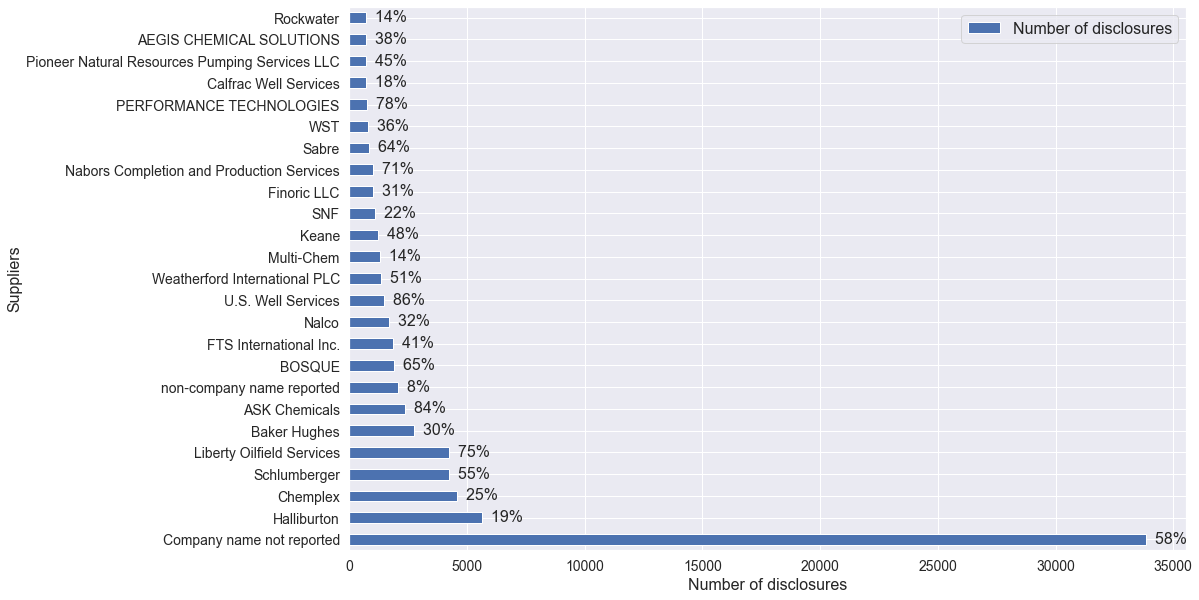

In [32]:
num_sup=25
#get number disclosures/yr
tmp = master_df.groupby(['UploadKey','comm_Sup'],as_index=False)['bgCAS'].count()
tot_sup = tmp.groupby('comm_Sup',as_index=False)['UploadKey'].count().rename({'UploadKey':'tot_disc'},axis=1)



t = master_df[master_df.EPADWS=='Yes'].copy()
gb = t.groupby(['comm_Sup','UploadKey'],as_index=False)['bgCAS'].count()
#gb.comm_Sup = np.where(gb.comm_Sup=='Listed Above','non-company name reported',gb.comm_Sup)
gb1 = gb.groupby('comm_Sup',as_index=False)['UploadKey'].count().rename({'UploadKey':'num_disclosures'},axis=1)
gb1 = pd.merge(gb1,tot_sup,on='comm_Sup',how='left')
gb1['perc_disc'] = gb1.num_disclosures/gb1.tot_disc * 100
gb1 = gb1.sort_values('num_disclosures',ascending=False)
gb1.comm_Sup = np.where(gb1.comm_Sup=='Listed Above','non-company name reported',gb1.comm_Sup)
gb1.comm_Sup = np.where(gb1.comm_Sup=='MISSING','Company name not reported',gb1.comm_Sup)
gb1.comm_Sup = np.where(gb1.comm_Sup=='ASK','ASK Chemicals',gb1.comm_Sup)
gb1.comm_Sup = np.where(gb1.comm_Sup=='CWS','Calfrac Well Services',gb1.comm_Sup)
gb1.comm_Sup = np.where(gb1.comm_Sup=='WFT','Weatherford International PLC',gb1.comm_Sup)
gb1.comm_Sup = np.where(gb1.comm_Sup=='FTSI','FTS International Inc.',gb1.comm_Sup)

ax = gb1[:25].plot.barh('comm_Sup','num_disclosures',figsize=(15,10))
ax.legend(labels =['Number of disclosures'],fontsize=16)
ax.tick_params(axis="y", labelsize=14)
ax.tick_params(axis="x", labelsize=14)
plt.xlabel('Number of disclosures',fontsize=16);
plt.ylabel('Suppliers',fontsize=16)
#plt.title('SUPPLIERS: Number of disclosures reporting chemicals on SDWA lists',fontsize=20);
perc_lst = gb1[:num_sup].perc_disc.tolist()
#print(perc_lst)
for i,p in enumerate(ax.patches):
    width = p.get_width()
#     nw = f'  {round_sig(width,8)}'
    #print(i,perc_lst[i])
    nw = f'  {int(round(perc_lst[i],0))}%'
    plt.text(p.get_width(), p.get_y()+0.55*p.get_height(),
             nw,
             ha='left', va='center',fontsize=16)
    
plt.savefig(out_figs+'Suppliers.png',pad_inches=1,bbox_inches = 'tight', dpi = 900)

# Primary Supplier

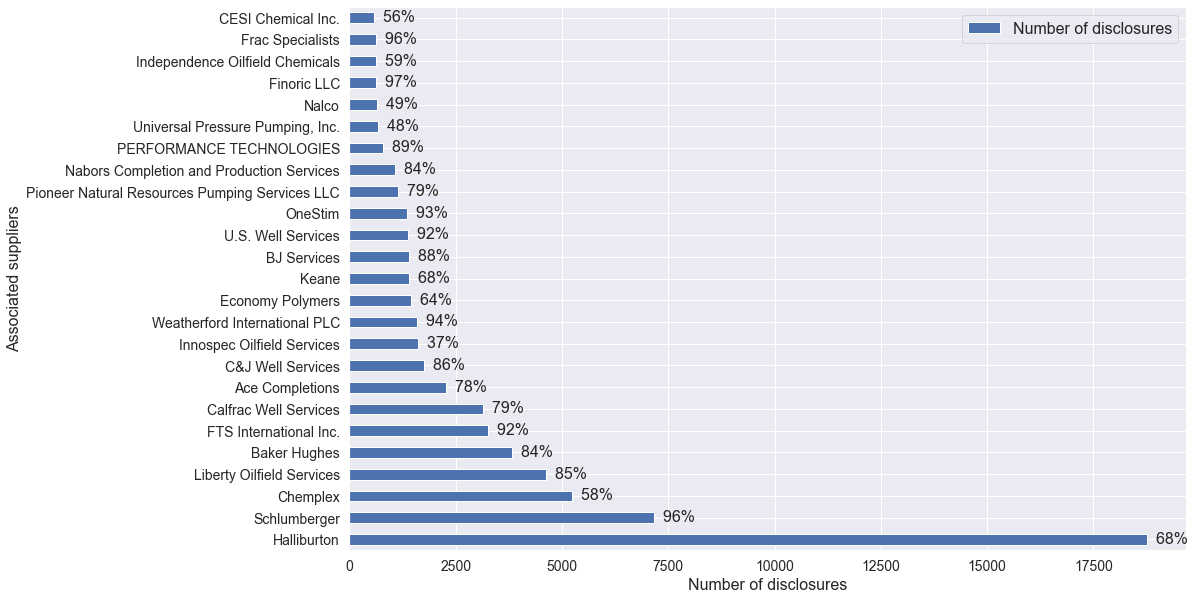

In [33]:
num_prim=25
#get number disclosures/yr
tmp = master_df.groupby(['UploadKey','comm_Prim'],as_index=False)['bgCAS'].count()
tot_sup = tmp.groupby('comm_Prim',as_index=False)['UploadKey'].count().rename({'UploadKey':'tot_disc'},axis=1)



t = master_df[master_df.EPADWS=='Yes'].copy()
gb = t.groupby(['comm_Prim','UploadKey'],as_index=False)['bgCAS'].count()
#gb.comm_Sup = np.where(gb.comm_Sup=='Listed Above','non-company name reported',gb.comm_Sup)
gb1 = gb.groupby('comm_Prim',as_index=False)['UploadKey'].count().rename({'UploadKey':'num_disclosures'},axis=1)
gb1 = pd.merge(gb1,tot_sup,on='comm_Prim',how='left')
gb1['perc_disc'] = gb1.num_disclosures/gb1.tot_disc * 100
gb1 = gb1.sort_values('num_disclosures',ascending=False)
# gb1.comm_Prim = np.where(gb1.comm_Prim=='Listed Above','non-company name reported',gb1.comm_Prim)
# gb1.comm_Prim = np.where(gb1.comm_Prim=='MISSING','Company name not reported',gb1.comm_Prim)
# gb1.comm_Prim = np.where(gb1.comm_Prim=='ASK','ASK Chemicals',gb1.comm_Prim)
gb1.comm_Prim = np.where(gb1.comm_Prim=='CWS','Calfrac Well Services',gb1.comm_Prim)
gb1.comm_Prim = np.where(gb1.comm_Prim=='WFT','Weatherford International PLC',gb1.comm_Prim)
gb1.comm_Prim = np.where(gb1.comm_Prim=='FTSI','FTS International Inc.',gb1.comm_Prim)
gb1.comm_Prim = np.where(gb1.comm_Prim=='CESI','CESI Chemical Inc.',gb1.comm_Prim)


ax = gb1[:num_prim].plot.barh('comm_Prim','num_disclosures',figsize=(15,10))
ax.legend(labels =['Number of disclosures'],fontsize=16)
ax.tick_params(axis="y", labelsize=14)
ax.tick_params(axis="x", labelsize=14)
plt.xlabel('Number of disclosures',fontsize=16);
plt.ylabel('Associated suppliers',fontsize=16)
#plt.title('Associated suppliers: Number of disclosures reporting chemicals on SDWA lists',fontsize=20);
perc_lst = gb1[:num_prim].perc_disc.tolist()
#print(perc_lst)
for i,p in enumerate(ax.patches):
    width = p.get_width()
#     nw = f'  {round_sig(width,8)}'
    #print(i,perc_lst[i])
    nw = f'  {int(round(perc_lst[i],0))}%'
    plt.text(p.get_width(), p.get_y()+0.55*p.get_height(),
             nw,
             ha='left', va='center',fontsize=16)
plt.savefig(out_figs+'Prim_supp.png',pad_inches=1,bbox_inches = 'tight', dpi = 900)

---
# Getting the Reportable Quantities from Cornell Law website

In [34]:
# sdf = df[df.in_std_filtered]  # This is the FF bulk data, filtered
# sdf = sdf[(sdf.date.dt.year>2013)&(sdf.date.dt.year<2022)]
sdf = master_df.copy()

def get_lbs(s):
    # separate the pounds from the kg in that cell; keep the pounds
    try:
        t = s.split('(')
        return float(t[0])
    except:
        return s
    
rq = pd.read_html('https://www.law.cornell.edu/cfr/text/40/302.4')
rq = rq[0] # take just the first table
rq.columns = ['chem_name','CASRN','statutory_code','RCRA_waste_num','reportable_quantity']
print(rq.head())

rq = rq[(rq.CASRN.notna())&(~(rq.CASRN=='N.A.'))&(~(rq.CASRN=='N.A'))]
rq['rq_lbs'] = rq.reportable_quantity.map(lambda x: get_lbs(x))
rq.to_csv('./tmp/rq.csv')

               chem_name       CASRN  statutory_code RCRA_waste_num  \
0                  A2213  30558-43-1             4.0           U394   
1           Acenaphthene     83-32-9             2.0            NaN   
2         Acenaphthylene    208-96-8             2.0            NaN   
3           Acetaldehyde     75-07-0           134.0           U001   
4  Acetaldehyde, chloro-    107-20-0             4.0           P023   

  reportable_quantity  
0         5000 (2270)  
1          100 (45.4)  
2         5000 (2270)  
3          1000 (454)  
4          1000 (454)  


In [35]:
# need to deal with non-hyphenated CAS and multiple CAS in one cell
cas = []
rqlbs = []
for i,row in rq.iterrows():
    clst = row.CASRN.split()
    for tcas in clst:
        if '-' in tcas: # already hypenated
            cas.append(tcas)
            rqlbs.append(row.rq_lbs)
        else:
            ncas = tcas[:-3]+'-'+tcas[-3:-1]+'-'+tcas[-1]
            print(f'was {tcas}, now is: {ncas}')
            cas.append(ncas)
            rqlbs.append(row.rq_lbs)
rq = pd.DataFrame({'CASRN':cas,'rq_lbs':rqlbs})        

In [36]:
print(f"raw size: {len(rq)}, without CASRN dupes: {len(rq[~rq[['CASRN']].duplicated()])}; without CASRN|rq dupes: {len(rq[~rq[['CASRN','rq_lbs']].duplicated()])}")
tt = rq[~rq[['CASRN','rq_lbs']].duplicated()]
tt[tt.CASRN.duplicated(keep=False)]

raw size: 1212, without CASRN dupes: 765; without CASRN|rq dupes: 767


,CASRN,rq_lbs
157,1330-20-7,100.0
802,25154-55-6,**
803,25154-55-6,100.0
1196,1330-20-7,1000.0


So there are multiple rows in the table for some chemicals.  For the most part, those duplicates have the same reportable quantities.  One exception is 1330-20-7 where the later one (for "spent" solvents) has a higher rq.  I am keeping only the first, non-spent rq values. Another exception is 25154-55-6 where the first record has no rq.  We drop that.

In [37]:
# now filter duplicates and merge into main FF data
rq = rq[~(rq.rq_lbs=='**')]
rq = rq[~rq.CASRN.duplicated()]
caslst = rq.CASRN.unique().tolist()
bgCASlst = sdf.bgCAS.unique().tolist()

cas = []
rq_lst = []
for i,row in rq.iterrows():
    if row.CASRN in bgCASlst:
        cas.append(row.CASRN)
        rq_lst.append(row.rq_lbs)
out = pd.DataFrame({'bgCAS':cas,'rq_lbs':rq_lst})
print(out)
out.to_csv('RQ_values.csv',index=False)
out[out.bgCAS.duplicated(keep=False)].sort_values('bgCAS')

         bgCAS  rq_lbs
0      75-07-0  1000.0
1      64-19-7  5000.0
2     141-78-6  5000.0
3     108-24-7  5000.0
4      67-64-1  5000.0
..         ...     ...
96    108-05-4  5000.0
97    108-38-3  1000.0
98     95-47-6  1000.0
99   7646-85-7  1000.0
100  7733-02-0  1000.0

[101 rows x 2 columns]


,bgCAS,rq_lbs


In [38]:
t = sdf[sdf.bgCAS.isin(caslst)]
#print(len(t))
t = pd.merge(t,out,on='bgCAS',how='left',validate='m:1')
print(f'Number SDWA chem on the RQ list: {len(t[t.is_on_DWSHA].bgCAS.unique())}')
c1 = (t.is_on_DWSHA) & ~(t.epa_preferred_name.isin(['Antimony']))
gb = t[c1].groupby(['UploadKey','epa_preferred_name'],as_index=False)['calcMass'].sum()
gb1 = t[c1].groupby(['UploadKey','epa_preferred_name'],as_index=False)['rq_lbs'].first()
mg = pd.merge(gb,gb1,on=['UploadKey','epa_preferred_name'],how='left')
mg['over_rq'] = mg.calcMass>=mg.rq_lbs
print(f'Total number of disclosures over RQ: {len(mg[mg.over_rq].UploadKey.unique())}')
gbout1 = mg.groupby('epa_preferred_name',as_index=False)['UploadKey'].count().rename({'UploadKey':'total_disc'},axis=1)
gbout2 = mg.groupby('epa_preferred_name',as_index=False)['over_rq'].sum()

out_rq = pd.merge(gbout1,gbout2,on='epa_preferred_name',how='left')
out_rq['percover'] = out_rq.over_rq/out_rq.total_disc *100
print(f'Sum of over_rq col: {out_rq.over_rq.sum()}')
out_rq
# t[(t.calcMass>t.rq_lbs)&(t.is_on_DWSHA)].epa_preferred_name.value_counts()  # KEEP ONLY SDWA chem

Number SDWA chem on the RQ list: 23
Total number of disclosures over RQ: 19700
Sum of over_rq col: 20887


,epa_preferred_name,total_disc,over_rq,percover
0,"1,3-Dichloropropene",32,19,59.375000
1,"1,4-Dioxane",2747,28,1.019294
2,Acrylamide,22065,167,0.756855
3,Acrylonitrile,373,60,16.085791
4,Ammonia,1503,589,39.188290
5,Arsenic,239,150,62.761506
6,Benzene,111,101,90.990991
7,Chloromethane,461,0,0.000000
8,Cumene,28,0,0.000000
9,Di(2-ethylhexyl) phthalate,42,1,2.380952


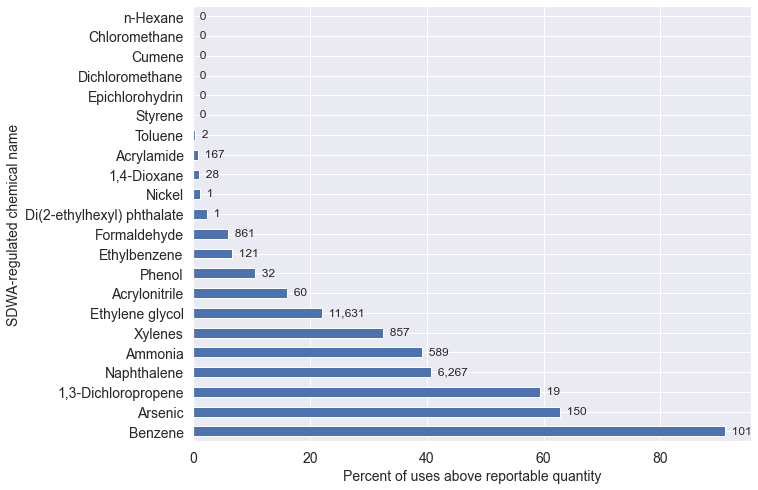

In [39]:

out_rq = out_rq.sort_values('percover',ascending=False)
ax = out_rq.plot.barh('epa_preferred_name','percover',figsize=(10,8),legend=False)
# ax.set_title('Percent of uses (disclosures) that surpass "reportable" quantities',fontsize=18) 
ax.set_title('') 
ax.tick_params(axis="y", labelsize=14)
ax.tick_params(axis="x", labelsize=14)
plt.xlabel('Percent of uses above reportable quantity',fontsize=14);
plt.ylabel('SDWA-regulated chemical name',fontsize=14)
cnt_lst = out_rq.over_rq.tolist()
for i,p in enumerate(ax.patches):
    width = p.get_width()
#     nw = f'  {round_sig(width,8)}'
    #print(i,perc_lst[i])
    nw = f'  {cnt_lst[i]:,}'
    plt.text(p.get_width(), p.get_y()+0.55*p.get_height(),
             nw,
             ha='left', va='center',fontsize=12)
    
plt.savefig(out_figs+'rq.png',pad_inches=1,bbox_inches = 'tight', dpi = 900)

In [40]:
# SDWA chemical NOT on the RQ list
l1 = sdf[(sdf.is_on_DWSHA)&(~sdf.bgCAS.isin(caslst))].epa_preferred_name.unique().tolist()
l2 = sdf[(sdf.is_on_DWSHA)&(~sdf.bgCAS.isin(caslst))].bgCAS.unique().tolist()
nots = pd.DataFrame({'name':l1,'bgCAS':l2})
#nots.to_csv('./tmp/temp.csv',index=False)
nots

,name,bgCAS
0,Chlorine dioxide,10049-04-4
1,"1,2,4-Trimethylbenzene",95-63-6
2,"1,3,5-Trimethylbenzene",108-67-8
3,Chlorite,14998-27-7
4,Boron,7440-42-8
